In [3]:
import torch.nn as nn
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import chess

import train
import preprocess
import compare
import nn_models

In [4]:
df = pd.read_csv("data/cleaned/chess_train_val_small.csv")

In [5]:
y = df["advantage"].to_numpy(dtype=np.float32)
fens = df["canonical_fen"]
path = Path("scratch/X_small.dat")

recreate_mmap = False
if recreate_mmap:
    X = preprocess.build_memmap(fens, path, np.float32)
else:
    X = np.memmap(
        path, dtype=np.float32, mode="r", shape=(len(fens), *preprocess.BOARD_SHAPE)
    )

building memmap: 100%|██████████| 1285186/1285186 [00:15<00:00, 83391.79it/s]


# Transformation of target

<Axes: ylabel='Count'>

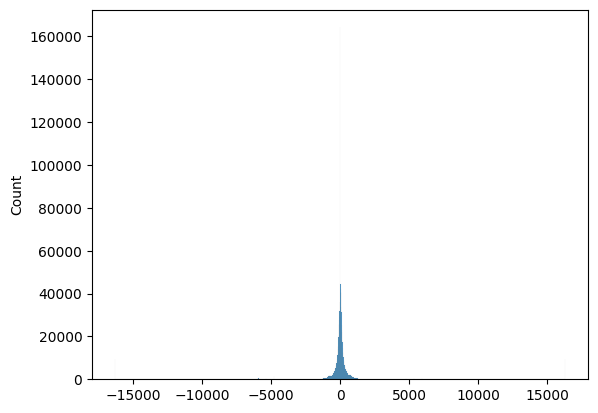

In [6]:
# original target has very long tail

sns.histplot(y)

<Axes: ylabel='Count'>

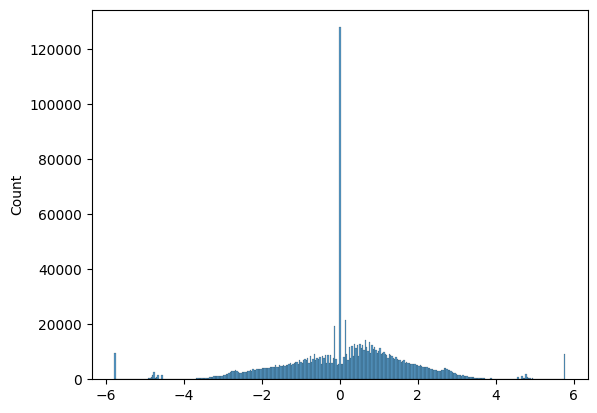

In [7]:
# using an asinh transform has less of a tail (I like it)

y_asinh = np.arcsinh(y / 100.0)
sns.histplot(y_asinh)

<Axes: ylabel='Count'>

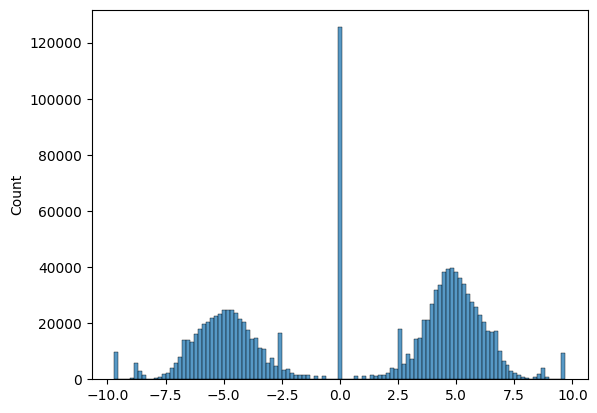

In [8]:
# with signed_log I think distortion around 0 is too big

y_signed_log = np.sign(y) * np.log(np.abs(y) + 1)
sns.histplot(y_signed_log)

<Axes: ylabel='Count'>

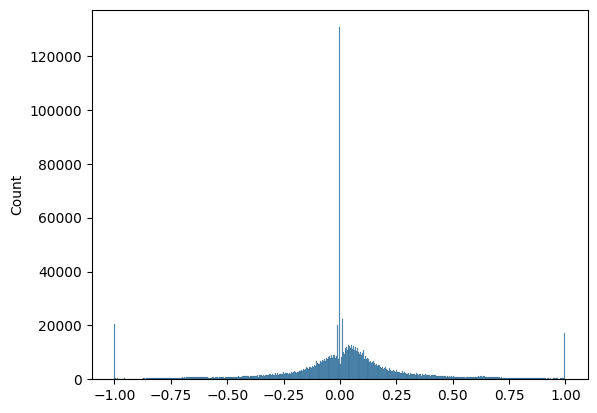

In [9]:
# tanh looks also good but clipps a lot to the extremes -1,1

y_tanh = np.tanh(y / 1000)
sns.histplot(y_tanh)

# NN Models and losses

The models are in `nn_models.py`

In [10]:
# classic: Mean squared error, sensitive to outliers
loss_mse = nn.MSELoss()

# less outlier punishment
loss_mae = nn.L1Loss()

# mix: mse for small errors, mae for large errors
loss_hubner = nn.SmoothL1Loss()

# Compare Loss Function

In [16]:
models_loss = {}

for title, loss_fn in [("mse", loss_mse), ("mae", loss_mae), ("hubner", loss_hubner)]:
    print(f"==={title}===")
    nn = nn_models.SmallCNNFast()
    models = train.train(
        X,
        y,
        nn,
        lr=1e-3,
        epochs=10,
        load_workers=1,
        batch_size=4096,
        val_split=0.01,
        seed=0,
        loss_function=loss_fn,
    )
    models_loss[title] = models[0]
    print("\n")

===mse===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 26.24batches/s, avg_loss=4.1e+6] 


  train_loss=4496620.237070  val_loss=4096330.353280
PARAM CHANGE (average): 70.7664
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 43.95batches/s, avg_loss=3.78e+6]


  train_loss=4151553.225216  val_loss=3782071.720411
PARAM CHANGE (average): 33.626
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 41.25batches/s, avg_loss=3.56e+6]


  train_loss=3834147.580436  val_loss=3555683.633025
PARAM CHANGE (average): 20.2178
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 44.98batches/s, avg_loss=3.35e+6]


  train_loss=3620519.824664  val_loss=3350586.561629
PARAM CHANGE (average): 12.8267
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 51.90batches/s, avg_loss=3.29e+6]


  train_loss=3500852.317919  val_loss=3285836.106918
PARAM CHANGE (average): 7.85937
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 47.19batches/s, avg_loss=3.27e+6]


  train_loss=3441769.052359  val_loss=3267964.846977
PARAM CHANGE (average): 4.94541
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 51.76batches/s, avg_loss=3.23e+6]


  train_loss=3407027.232644  val_loss=3226453.601471
PARAM CHANGE (average): 3.17632
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 42.72batches/s, avg_loss=3.2e+6]


  train_loss=3387354.164426  val_loss=3199849.507470
PARAM CHANGE (average): 1.95838
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 50.44batches/s, avg_loss=3.19e+6]


  train_loss=3373693.572397  val_loss=3193489.826784
PARAM CHANGE (average): 0.946381
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 36.52batches/s, avg_loss=3.19e+6]


  train_loss=3365840.098591  val_loss=3190152.222862
PARAM CHANGE (average): 0.299414


===mae===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 24.24batches/s, avg_loss=499]


  train_loss=528.630120  val_loss=499.311212
PARAM CHANGE (average): 65.8082
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 42.83batches/s, avg_loss=490]


  train_loss=512.311386  val_loss=489.994438
PARAM CHANGE (average): 22.7189
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 44.01batches/s, avg_loss=485]


  train_loss=505.321504  val_loss=484.785052
PARAM CHANGE (average): 15.8738
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 47.44batches/s, avg_loss=480]


  train_loss=500.428537  val_loss=479.961179
PARAM CHANGE (average): 12.839
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 47.07batches/s, avg_loss=476]


  train_loss=496.522351  val_loss=476.476187
PARAM CHANGE (average): 9.84894
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 53.64batches/s, avg_loss=475]


  train_loss=493.830927  val_loss=474.535033
PARAM CHANGE (average): 7.57801
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 44.70batches/s, avg_loss=472]


  train_loss=491.762533  val_loss=472.388203
PARAM CHANGE (average): 5.24483
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 43.98batches/s, avg_loss=472]


  train_loss=490.405085  val_loss=472.226958
PARAM CHANGE (average): 3.3026
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 28.52batches/s, avg_loss=472]


  train_loss=489.632562  val_loss=471.682584
PARAM CHANGE (average): 1.60889
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 44.82batches/s, avg_loss=472]


  train_loss=489.302757  val_loss=471.533741
PARAM CHANGE (average): 0.452036


===hubner===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 24.09batches/s, avg_loss=500]


  train_loss=528.377351  val_loss=499.564350
PARAM CHANGE (average): 65.2115
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 48.02batches/s, avg_loss=490]


  train_loss=512.500932  val_loss=489.972866
PARAM CHANGE (average): 21.7978
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 53.01batches/s, avg_loss=485]


  train_loss=505.374965  val_loss=485.194548
PARAM CHANGE (average): 15.849
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 49.44batches/s, avg_loss=481]


  train_loss=500.210219  val_loss=480.726076
PARAM CHANGE (average): 12.4475
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 44.28batches/s, avg_loss=476]


  train_loss=496.093696  val_loss=476.171957
PARAM CHANGE (average): 9.78083
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 49.09batches/s, avg_loss=475]


  train_loss=493.199871  val_loss=474.533670
PARAM CHANGE (average): 7.2692
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 49.50batches/s, avg_loss=472]


  train_loss=491.069158  val_loss=472.076056
PARAM CHANGE (average): 5.11501
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 49.38batches/s, avg_loss=471]


  train_loss=489.704039  val_loss=471.201702
PARAM CHANGE (average): 3.24388
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 48.94batches/s, avg_loss=470]


  train_loss=488.796447  val_loss=470.425552
PARAM CHANGE (average): 1.57217
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 48.59batches/s, avg_loss=471]


  train_loss=488.493233  val_loss=470.587666
PARAM CHANGE (average): 0.449284




When comparing these models the results are actually inconclusive (difference most likely just random noise).

Maybe with more data a proper decision could be made or longer training or... well... I don't have got time for this. We will just stick with `hubner_loss` (that's my expert decision :D) and move on

In [17]:
model1 = nn_models.SmallCNNFast()
model2 = nn_models.SmallCNNFast()

for m1, m2 in [("mse", "mae"), ("mse", "hubner"), ("mae", "hubner")]:
    model1.load_state_dict(models_loss[m1])
    model2.load_state_dict(models_loss[m2])
    print(f"{m1} vs {m2}: {compare.war(model1, model2, games_per_side=50)}")

mse vs mae: {'model1': 13, 'model2': 4, 'draw': 83}
mse vs hubner: {'model1': 1, 'model2': 2, 'draw': 97}
mae vs hubner: {'model1': 2, 'model2': 3, 'draw': 95}


# Compare Transforms

unlikely that this will be any more enlightening, but I want to try it anyway :D

In [19]:
models_transform = {}

for title, y_t in [
    ("identity", y),
    ("asinh", y_asinh),
    ("signed_log", y_signed_log),
    ("tanh", y_tanh),
]:
    print(f"==={title}===")
    model = nn_models.SmallCNNFast(in_channels=preprocess.NUM_CHANNELS)
    models = train.train(
        X,
        y_t,
        model,
        seed=0,
        lr=1e-3,
        epochs=10,
        val_split=0.01,
        load_workers=1,
        batch_size=4096,
        loss_function=loss_hubner,
    )
    models_transform[title] = models[0]
    print("\n")

===identity===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 21.10batches/s, avg_loss=500]


  train_loss=528.377351  val_loss=499.564350
PARAM CHANGE (average): 65.2115
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 14.09batches/s, avg_loss=490]


  train_loss=512.500932  val_loss=489.972866
PARAM CHANGE (average): 21.7978
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 22.67batches/s, avg_loss=485]


  train_loss=505.374965  val_loss=485.194548
PARAM CHANGE (average): 15.849
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 26.02batches/s, avg_loss=481]


  train_loss=500.210219  val_loss=480.726076
PARAM CHANGE (average): 12.4475
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 17.58batches/s, avg_loss=476]


  train_loss=496.093696  val_loss=476.171957
PARAM CHANGE (average): 9.78083
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 25.73batches/s, avg_loss=475]


  train_loss=493.199871  val_loss=474.533670
PARAM CHANGE (average): 7.2692
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 30.03batches/s, avg_loss=472]


  train_loss=491.069158  val_loss=472.076056
PARAM CHANGE (average): 5.11501
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 19.48batches/s, avg_loss=471]


  train_loss=489.704039  val_loss=471.201702
PARAM CHANGE (average): 3.24388
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 35.96batches/s, avg_loss=470]


  train_loss=488.796447  val_loss=470.425552
PARAM CHANGE (average): 1.57217
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 23.20batches/s, avg_loss=471]


  train_loss=488.493233  val_loss=470.587666
PARAM CHANGE (average): 0.449284


===asinh===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 11.33batches/s, avg_loss=0.636]


  train_loss=0.701727  val_loss=0.635874
PARAM CHANGE (average): 22.4185
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 25.79batches/s, avg_loss=0.586]


  train_loss=0.621324  val_loss=0.585630
PARAM CHANGE (average): 13.754
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 21.19batches/s, avg_loss=0.56] 


  train_loss=0.585253  val_loss=0.559847
PARAM CHANGE (average): 10.4681
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 24.05batches/s, avg_loss=0.543]


  train_loss=0.563010  val_loss=0.542743
PARAM CHANGE (average): 7.97853
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 24.12batches/s, avg_loss=0.529]


  train_loss=0.548923  val_loss=0.529252
PARAM CHANGE (average): 5.94587
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 23.38batches/s, avg_loss=0.522]


  train_loss=0.539151  val_loss=0.522007
PARAM CHANGE (average): 4.21098
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 19.70batches/s, avg_loss=0.515]


  train_loss=0.531415  val_loss=0.514962
PARAM CHANGE (average): 2.86217
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 30.39batches/s, avg_loss=0.514]


  train_loss=0.527139  val_loss=0.514048
PARAM CHANGE (average): 1.75019
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 19.79batches/s, avg_loss=0.512]


  train_loss=0.524316  val_loss=0.512049
PARAM CHANGE (average): 0.845762
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 24.04batches/s, avg_loss=0.51] 


  train_loss=0.522936  val_loss=0.510488
PARAM CHANGE (average): 0.247571


===signed_log===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 24.54batches/s, avg_loss=2.79]


  train_loss=3.135461  val_loss=2.785630
PARAM CHANGE (average): 33.0833
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 49.75batches/s, avg_loss=2.7]


  train_loss=2.755908  val_loss=2.701092
PARAM CHANGE (average): 12.4625
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 50.11batches/s, avg_loss=2.62]


  train_loss=2.671663  val_loss=2.622364
PARAM CHANGE (average): 9.21409
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 37.47batches/s, avg_loss=2.55]


  train_loss=2.611457  val_loss=2.549152
PARAM CHANGE (average): 7.6636
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 49.97batches/s, avg_loss=2.51]


  train_loss=2.560313  val_loss=2.508185
PARAM CHANGE (average): 5.96892
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 49.63batches/s, avg_loss=2.48]


  train_loss=2.525137  val_loss=2.478106
PARAM CHANGE (average): 4.27888
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 38.94batches/s, avg_loss=2.44]


  train_loss=2.495129  val_loss=2.441382
PARAM CHANGE (average): 2.92089
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 49.88batches/s, avg_loss=2.43]


  train_loss=2.480329  val_loss=2.427042
PARAM CHANGE (average): 1.74819
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 42.22batches/s, avg_loss=2.42]


  train_loss=2.469209  val_loss=2.419959
PARAM CHANGE (average): 0.864778
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 43.74batches/s, avg_loss=2.42]


  train_loss=2.465192  val_loss=2.424139
PARAM CHANGE (average): 0.258136


===tanh===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 21.40batches/s, avg_loss=0.0378]


  train_loss=0.043833  val_loss=0.037761
PARAM CHANGE (average): 16.5523
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 40.92batches/s, avg_loss=0.0344]


  train_loss=0.036884  val_loss=0.034377
PARAM CHANGE (average): 11.2133
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 45.44batches/s, avg_loss=0.0329]


  train_loss=0.034231  val_loss=0.032937
PARAM CHANGE (average): 8.85885
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 39.27batches/s, avg_loss=0.0316]


  train_loss=0.032702  val_loss=0.031589
PARAM CHANGE (average): 6.7052
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 34.02batches/s, avg_loss=0.031] 


  train_loss=0.031694  val_loss=0.030989
PARAM CHANGE (average): 5.25376
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 43.23batches/s, avg_loss=0.0305]


  train_loss=0.031042  val_loss=0.030521
PARAM CHANGE (average): 3.889
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 44.48batches/s, avg_loss=0.03]


  train_loss=0.030534  val_loss=0.029990
PARAM CHANGE (average): 2.76937
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 41.10batches/s, avg_loss=0.0297]


  train_loss=0.030220  val_loss=0.029732
PARAM CHANGE (average): 1.66332
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 43.21batches/s, avg_loss=0.0296]


  train_loss=0.029989  val_loss=0.029589
PARAM CHANGE (average): 0.807914
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 45.11batches/s, avg_loss=0.0296]


  train_loss=0.029912  val_loss=0.029562
PARAM CHANGE (average): 0.242105




Well, this also is inconclusive. That calls for an expert decision once more. Let's stick with `asinh`

In [20]:
all = ["identity", "asinh", "signed_log", "tanh"]

# I included same vs same just so we can see how much lucks decides in these games
for i in range(4):
    m1 = all[i]
    for j in range(i, 4):
        m2 = all[j]
        model1.load_state_dict(models_transform[m1])
        model2.load_state_dict(models_transform[m2])
        print(f"{m1} vs {m2}: {compare.war(model1, model2, games_per_side=50)}")

identity vs identity: {'model1': 5, 'model2': 2, 'draw': 93}
identity vs asinh: {'model1': 4, 'model2': 1, 'draw': 95}
identity vs signed_log: {'model1': 1, 'model2': 9, 'draw': 90}
identity vs tanh: {'model1': 4, 'model2': 2, 'draw': 94}
asinh vs asinh: {'model1': 2, 'model2': 1, 'draw': 97}
asinh vs signed_log: {'model1': 3, 'model2': 2, 'draw': 95}
asinh vs tanh: {'model1': 2, 'model2': 3, 'draw': 95}
signed_log vs signed_log: {'model1': 4, 'model2': 1, 'draw': 95}
signed_log vs tanh: {'model1': 2, 'model2': 0, 'draw': 98}
tanh vs tanh: {'model1': 2, 'model2': 4, 'draw': 94}


To see what's going on let's check out some games. We can see that they just end with no pieces on the board. Another better metric for these bad models would maybe be to see the amount of material after a game.

8/8/8/5k2/8/8/1K6/8 b - - 0 217


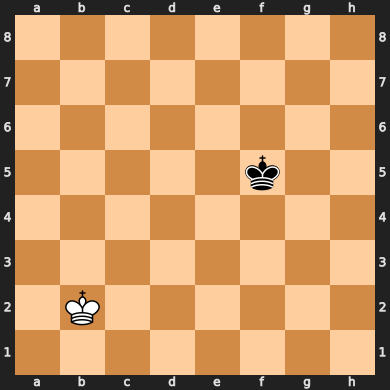

In [21]:
# let's check out some games

model1.load_state_dict(models_transform["identity"])
model2.load_state_dict(models_transform["asinh"])

_, final_board = compare.fight(model1, model2, 0.1, 20)
print(final_board)
chess.Board(final_board)

R1k5/8/1pK5/1r1P3p/P4r2/8/8/7r b - - 0 50


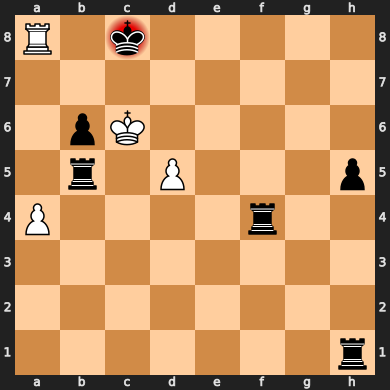

In [22]:
_, final_board = compare.fight(model1, model2, 0.1, 20)
print(final_board)
chess.Board(final_board)

8/8/5B2/8/8/5k2/2B5/1K6 w - - 150 231


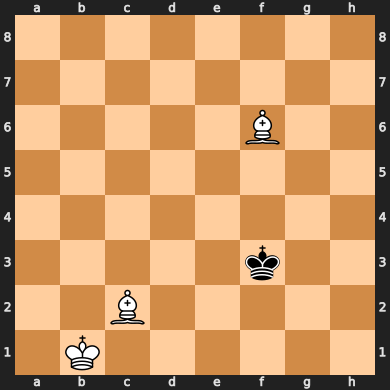

In [23]:
_, final_board = compare.fight(model1, model2, 0.1, 20)
print(final_board)
chess.Board(final_board)

3k4/8/8/6r1/1K6/8/8/N7 w - - 150 171


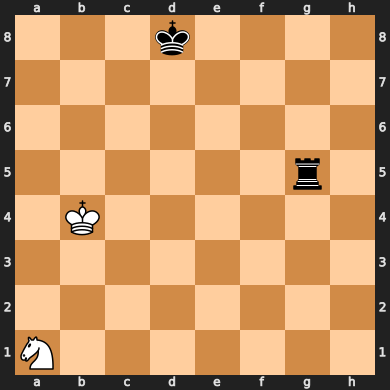

In [24]:
_, final_board = compare.fight(model1, model2, 0.1, 20)
print(final_board)
chess.Board(final_board)

# Compare NN Models

In [26]:
models_nn = {}

for title, model in [
    ("small", nn_models.SmallCNNFast()),
    ("medium", nn_models.MediumResNet()),
    # ("large", nn_models.LargeResNetSE()), <-- we have to skip large because it is too slow
]:
    print(f"==={title}===")
    models = train.train(
        X,
        y_asinh,
        model,
        lr=1e-3,
        epochs=10,
        load_workers=1,
        batch_size=4096,
        val_split=0.01,
        seed=0,
        loss_function=loss_hubner,
    )
    models_transform[title] = models[0]
    print("\n")

===small===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:00<00:00, 23.84batches/s, avg_loss=0.636]


  train_loss=0.701727  val_loss=0.635874
PARAM CHANGE (average): 22.4185
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:00<00:00, 48.46batches/s, avg_loss=0.586]


  train_loss=0.621324  val_loss=0.585630
PARAM CHANGE (average): 13.754
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00, 48.87batches/s, avg_loss=0.56]


  train_loss=0.585253  val_loss=0.559847
PARAM CHANGE (average): 10.4681
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00, 48.99batches/s, avg_loss=0.543]


  train_loss=0.563010  val_loss=0.542743
PARAM CHANGE (average): 7.97853
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:00<00:00, 43.71batches/s, avg_loss=0.529]


  train_loss=0.548923  val_loss=0.529252
PARAM CHANGE (average): 5.94587
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:00<00:00, 43.26batches/s, avg_loss=0.522]


  train_loss=0.539151  val_loss=0.522007
PARAM CHANGE (average): 4.21098
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:00<00:00, 52.30batches/s, avg_loss=0.515]


  train_loss=0.531415  val_loss=0.514962
PARAM CHANGE (average): 2.86217
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:00<00:00, 55.04batches/s, avg_loss=0.514]


  train_loss=0.527139  val_loss=0.514048
PARAM CHANGE (average): 1.75019
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 53.16batches/s, avg_loss=0.512]


  train_loss=0.524316  val_loss=0.512049
PARAM CHANGE (average): 0.845762
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:00<00:00, 54.26batches/s, avg_loss=0.51]


  train_loss=0.522936  val_loss=0.510488
PARAM CHANGE (average): 0.247571


===medium===
Epoch 1/10 — lr=0.001


valid: 100%|██████████| 4/4 [00:03<00:00,  1.16batches/s, avg_loss=0.636]


  train_loss=0.556448  val_loss=0.635823
PARAM CHANGE (average): 425.252
Epoch 2/10 — lr=0.00097553


valid: 100%|██████████| 4/4 [00:01<00:00,  3.65batches/s, avg_loss=0.57] 


  train_loss=0.445259  val_loss=0.569507
PARAM CHANGE (average): 212.617
Epoch 3/10 — lr=0.00090451


valid: 100%|██████████| 4/4 [00:00<00:00,  4.30batches/s, avg_loss=0.544]


  train_loss=0.411191  val_loss=0.543949
PARAM CHANGE (average): 187.391
Epoch 4/10 — lr=0.00079389


valid: 100%|██████████| 4/4 [00:00<00:00,  4.29batches/s, avg_loss=0.526]


  train_loss=0.389285  val_loss=0.526452
PARAM CHANGE (average): 164.642
Epoch 5/10 — lr=0.00065451


valid: 100%|██████████| 4/4 [00:01<00:00,  3.71batches/s, avg_loss=0.505]


  train_loss=0.372676  val_loss=0.505219
PARAM CHANGE (average): 143.015
Epoch 6/10 — lr=0.0005


valid: 100%|██████████| 4/4 [00:01<00:00,  2.59batches/s, avg_loss=0.392]


  train_loss=0.358379  val_loss=0.391575
PARAM CHANGE (average): 123.89
Epoch 7/10 — lr=0.00034549


valid: 100%|██████████| 4/4 [00:01<00:00,  2.30batches/s, avg_loss=0.455]


  train_loss=0.344753  val_loss=0.454626
PARAM CHANGE (average): 96.4748
Epoch 8/10 — lr=0.00020611


valid: 100%|██████████| 4/4 [00:01<00:00,  2.77batches/s, avg_loss=0.378]


  train_loss=0.334543  val_loss=0.377532
PARAM CHANGE (average): 65.8319
Epoch 9/10 — lr=9.5492e-05


valid: 100%|██████████| 4/4 [00:01<00:00,  2.31batches/s, avg_loss=0.426]


  train_loss=0.324692  val_loss=0.426160
PARAM CHANGE (average): 37.2699
Epoch 10/10 — lr=2.4472e-05


valid: 100%|██████████| 4/4 [00:01<00:00,  2.54batches/s, avg_loss=0.34] 


  train_loss=0.319886  val_loss=0.339609
PARAM CHANGE (average): 12.6982




The medium took much longer than the small model. So the big model is already out of question.


And even though `val_loss` is considerably better for the medium model it doesn't chage the game quality.

In [27]:
model_small = nn_models.SmallCNNFast()
model_medium = nn_models.MediumResNet()

# ups I accidently added to the wrong dict in the earlier cell
model_small.load_state_dict(models_transform["small"])
model_medium.load_state_dict(models_transform["medium"])

# I included same vs same just so we can see how much lucks decides in these games
print(
    f"nn-architecture small vs medium: {compare.war(model_small, model_medium, games_per_side=50)}"
)

nn-architecture small vs medium: {'model1': 2, 'model2': 2, 'draw': 96}


Here I checked some board to see if I can see something interesting. In this little sample it looks like black has more material at the end. But it could also just be the small samples size.

After this I just realized a problem in this approach. A trained model will most likely have troubles distinguishing very good positions from each other, i.e., it won't favour positions that lead to a mate over positions that lead to a mate but just later.

b7/8/1k6/8/8/7K/8/8 b - - 0 201


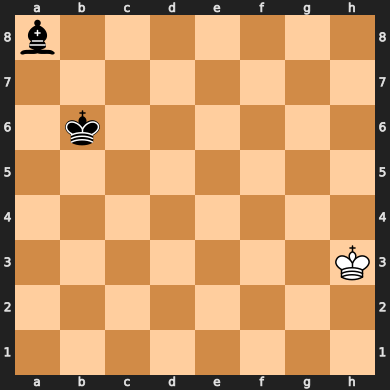

In [32]:
_, final_board = compare.fight(model_small, model_medium, 0.1, 20)
print(final_board)
chess.Board(final_board)

1q5k/8/8/7r/K3p1p1/8/1qr5/8 w - - 25 93


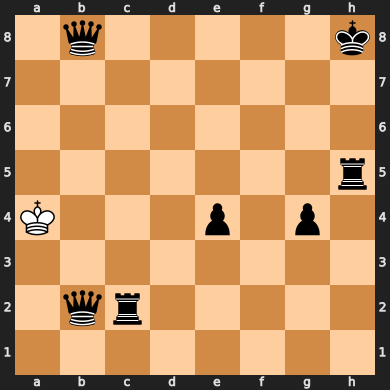

In [33]:
_, final_board = compare.fight(model_small, model_medium, 0.1, 20)
print(final_board)
chess.Board(final_board)

8/4k3/8/3K4/8/8/8/8 b - - 0 149


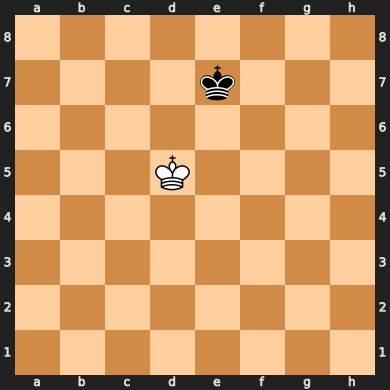

In [34]:
_, final_board = compare.fight(model_small, model_medium, 0.1, 20)
print(final_board)
chess.Board(final_board)

7k/1n6/8/8/8/8/8/2K5 w - - 0 146


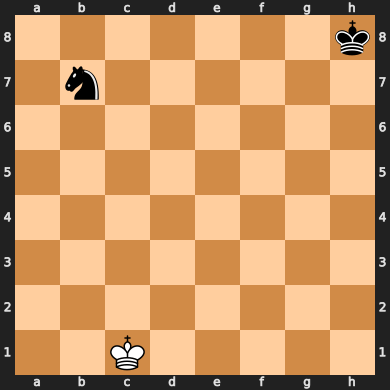

In [35]:
_, final_board = compare.fight(model_small, model_medium, 0.1, 20)
print(final_board)
chess.Board(final_board)

8/1n6/8/8/2K5/8/1k6/8 b - - 0 210


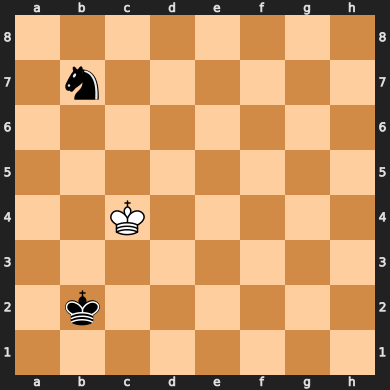

In [36]:
_, final_board = compare.fight(model_small, model_medium, 0.1, 20)
print(final_board)
chess.Board(final_board)